## Base class 

The example below illustrates fitting mixtures of experts (here: linear models) using EM.

Component (cluster) assignemtns are considered latent variables and updated, alternating with refitting componet models.

In principle one can optimize the full likelihood, but with EM we gain speed and simplicity when individual components are easy to fit (the case of linear models).

There are many extensions, like mixture density networks.<br/>
For more see https://publications.idiap.ch/downloads/reports/1997/com97-05.pdf and more recent literature.

In [1]:
from sklearn.base import BaseEstimator,RegressorMixin
from sklearn import linear_model
import numpy as np
from scipy import special,stats

class MixLinReg(BaseEstimator,RegressorMixin):
    
    ''' Mixture of linear models over latent components. Supports sample weights.
        Fitting by EM algorithm. 
        Based on https://publications.idiap.ch/downloads/reports/1997/com97-05.pdf '''
    
    def __init__(self,n_clusters=3,init_prior=10,**linreg_kwarg):
        ''' n_clusters is the number of components, init_prior is the alpha Dirichlet param, extra params passed to models '''
        self.n_clusters = n_clusters
        self.models = [linear_model.LinearRegression(**linreg_kwarg) for _ in range(n_clusters)]
        self.p_cluster = None
        self.X = None
        self.y = None
        self.sample_weight = None
        self.prior = stats.dirichlet(alpha=np.ones(n_clusters)*init_prior) # prior for cluster assignments
        super(MixLinReg,self).__init__()
        
    def _estep(self):
        ''' given fit models, updates the cluster probabilities (bayes rule)'''
        y_pred = np.concatenate([m.predict(self.X).reshape(-1,1) for m in self.models],1)
        res = (y_pred - self.y.reshape(-1,1))*self.sample_weight.reshape(-1,1)**0.5 # weight-standardized residuals
        sigma = res.std(0,keepdims=0)
        # compute the complete likelihood in logits (constants ignored, prior on clusters doesn't impact softmax)
        z =  np.log(self.p_cluster+1e-14) - np.log(sigma+1e-14) -np.log(sigma) - 0.5*(res/sigma)**2
        z =  z + 2*np.log(sigma) # add Jeffrey's prior
        return special.softmax(z,1)

    def _mstep(self):
        ''' given cluster weights, updates the models (calls fit with weights impacted by clusters)'''
        for (i,m) in enumerate(self.models):
            m.fit(self.X,self.y,sample_weight=self.p_cluster[:,i]*self.sample_weight)

    def fit(self,X,y,sample_weight=None,n_steps=100):
        ''' performs a sequence of E-M steps on the given data '''
        self.X = X
        self.y = y
        self.p_cluster = self.prior.rvs(size=(self.X.shape[0],))
        self.sample_weight = sample_weight if sample_weight is not None else np.array([1]) 
        for _ in range(n_steps):
            self._mstep()
            self.p_cluster=self._estep()

## Tests 

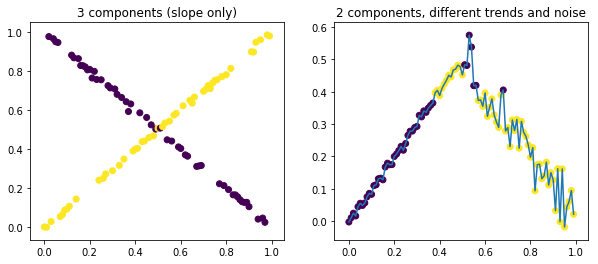

In [4]:
## toy datasets

from matplotlib import pyplot as plt

_,axs=plt.subplots(1,2,figsize=(10,4))

np.random.seed(1234)

X2=np.arange(0,100).reshape(-1,1)/100
y2=np.arange(0,100)/100
subset=np.random.randint(0,2,size=100).astype(bool)
y2[subset]=y2[subset]
y2[~subset]=1-y2[~subset]
y2=y2+np.random.normal(0,1e-2,size=y2.shape)

reg = MixLinReg(n_clusters=2,init_prior=10,fit_intercept=True)  
reg.fit(X2,y2,n_steps=100)
axs[0].scatter(X2,y2,c=reg.p_cluster.argmax(1))
axs[0].set_title('3 components (slope only)')

X2=np.arange(0,100)/100
y2=np.zeros(100)
y2[:50] = X2[:50]+np.random.normal(0,.01,size=50)
y2[50:] = 1-X2[50:]+np.random.normal(0,.05,size=50)
X2 = X2.reshape(-1,1)
plt.plot(X2,y2)

reg = MixLinReg(n_clusters=2,init_prior=1,fit_intercept=True)  
reg.fit(X2,y2,n_steps=100)
axs[1].scatter(X2,y2,c=reg.p_cluster.argmax(1))
axs[1].set_title('2 components, different trends and noise')

plt.show()

In [3]:
## we will model the aggregated revenue on the following quarter (hackaton data set)

import pandas as pd
import numpy as np
import itertools

X0=pd.read_csv('data.csv')

## splits - each has its own time series
units = ['Country','Product Desc','Product Series']

## do rolling sums
cols_to_cumsum = ['RUM_Units','RUM_Revenue','RUM_Margin']
X0=X0.set_index(units+['FY-Month']).sort_index()
unit_keys = list(itertools.product(X0.index.levels[0],X0.index.levels[1],X0.index.levels[2]))

for c in cols_to_cumsum:
    X0[c+'_target'] = np.nan
    X0[c+'_target2'] = np.nan
for k in unit_keys:
    X0.loc[k,[c+'_target' for c in cols_to_cumsum]] = X0.loc[k,cols_to_cumsum].rolling(3).sum().shift(-3).values
    X0.loc[k,[c+'_target2' for c in cols_to_cumsum]] = X0.loc[k,cols_to_cumsum].rolling(3).sum().shift(-6).values

## test if it works as expected 
assert(X0['RUM_Revenue'][1:4].sum()-X0['RUM_Revenue_target'][0]==0)

## build features

y0 = X0['RUM_Revenue_target']
y = y0

X=pd.get_dummies(X0.index.get_level_values('Country')).set_index(X0.index)
X=pd.concat([X,pd.get_dummies(X0.index.get_level_values('Product Desc')).set_index(X0.index)],1)
X=pd.concat([X0['RUM_Revenue'],X0['RUM_Units'],X0['RUM_Margin'],X],1)

## masking pathological examples
mask = (~y.isna()) & (y > 0)
y = y[mask]
X = X[mask]

## define the metric - MAPE loss (revenue is the target)

def mape(y_true,y):
    return np.nanmean(np.abs((y_true-y)/(y_true+1e-7)))

## scale somewhat, although here it doesn't matter as we will use matrices to fit

X1 = X.values
y1 = y.values.reshape(-1,1)/y.mean()
scale_X = ((X1/y1**0.5)**2).mean(0)**0.5
scale_X = ((X1/y1**0.5)).std(0)
X1 = X1/scale_X

## benchmark

reg=linear_model.LinearRegression(fit_intercept=False).fit(X,y,sample_weight=1/(y+1e-7)**1.0)
print('Benchmark: one model ',mape(y,reg.predict(X)))

np.random.seed(1234)

for i in range(3):
    reg=MixLinReg(n_clusters=3,init_prior=10)
    reg.fit(X1,y1,n_steps=100,sample_weight=1/y1.ravel())
    y_pred = np.concatenate([m.predict(X1) for m in reg.models],1)
    p_cluster = reg.p_cluster
    print('Mixture of 3 models (%s)'%i, mape(y1,np.take_along_axis(y_pred,p_cluster.argmax(1).reshape(-1,1),1)))
    for i in range(reg.n_clusters):
        mask=p_cluster.argmax(1)==i
        print('component %s'%i,mape(y1[mask],y_pred[mask,i].reshape(-1,1)))

Benchmark: one model  0.2850151344973567
Mixture of 3 models (0) 0.18228665921187232
component 0 0.23104567273242307
component 1 0.14831746201357174
component 2 0.09567086805095981
Mixture of 3 models (1) 0.14936718336983135
component 0 0.17147550116123128
component 1 0.18494502110356073
component 2 0.06567202384627982
Mixture of 3 models (2) 0.1603183128280002
component 0 0.12202085982193316
component 1 0.1807069428309877
component 2 0.14757272533970958
